In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
import time

from imblearn.over_sampling import SMOTE

In [2]:
def z_score_norm(X: np.ndarray):

    X_mean = np.mean(X, axis=0, dtype=np.float64)
    X_std = np.std(X, axis=0, dtype=np.float64)

    X_norm = (X - X_mean)/X_std

    # check for NaN values and replace NaN values with 0
    if (np.isnan(X_norm).any()):
        X_norm = np.nan_to_num(X_norm, nan=0) 
    
    return X_norm

In [3]:
def orig_train_val_split(X: np.ndarray, Y: np.ndarray, fold: str = "1", num_nodes: int = 827):

    if fold == "1": # Last 14 patients for validation/First 54 patients for training
    
        # For the training set (Original patients Only)  
        X_train = X[:54*num_nodes,:] 
        Y_train = Y[:54*num_nodes]

        # print('Y_train: %s' % Counter(Y_train))

        # For the validation set (Original patients Only)  
        X_val = X[54*num_nodes:68*num_nodes,:]
        Y_val = Y[54*num_nodes:68*num_nodes]

        # print('Y_val: %s' % Counter(Y_val))

        # print("Fold 1")

    return X_train, Y_train, X_val, Y_val  # type:ignore

In [4]:
def augment_data(X: np.ndarray, Y: np.ndarray, k_neighbors: int = 5, random_state: int = 100):

    sm = SMOTE(k_neighbors=k_neighbors, random_state=random_state) # type:ignore
    
    X_aug, Y_aug = sm.fit_resample(X, Y) # type:ignore
    
    return X_aug, Y_aug

In [5]:
def aug_train_val_split(X: np.ndarray, Y: np.ndarray, fold: str = "1", num_nodes: int = 827):

    if fold == "1": # Last 14 patients for validation/First 54 patients for training
    
        # For the training set and its augmentations
        total_ones_train = []
        for i in range(54):
            total_ones_train.append(sum(Y[num_nodes*i:num_nodes*(i+1)])) # original nodes for each patient 

        original_ones_train = sum(total_ones_train)
        original_zeros_train = len(total_ones_train)*num_nodes - sum(total_ones_train)

        augmented_ones_train = original_zeros_train - original_ones_train

        X_train = np.concatenate((X[:54*num_nodes,:], X[68*num_nodes:(68*num_nodes+augmented_ones_train),:]), axis=0)
        Y_train = np.concatenate((Y[:54*num_nodes], Y[68*num_nodes:(68*num_nodes+augmented_ones_train)]), axis=0)

        # print('Y_train: %s' % Counter(Y_train))

        # For the validation set and its augmentations
        X_val = np.concatenate((X[54*num_nodes:68*num_nodes,:], X[(68*num_nodes+augmented_ones_train):,:]), axis=0)
        Y_val = np.concatenate((Y[54*num_nodes:68*num_nodes], Y[(68*num_nodes+augmented_ones_train):]), axis=0)

        # print('Y_val: %s' % Counter(Y_val))

    return X_train, Y_train, X_val, Y_val  # type:ignore

In [12]:
def plot_tsne(X: np.ndarray, y: np.ndarray) -> None:

    # Convert to DataFrame
    feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]

    df = pd.DataFrame(X,columns=feat_cols)
    df['y'] = y    

    print('Size of the dataframe: {}'.format(df.shape))

    data_subset = df[feat_cols].values

    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
    tsne_results = tsne.fit_transform(data_subset)

    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    df['tsne-2d-one'] = tsne_results[:,0]
    df['tsne-2d-two'] = tsne_results[:,1]

    # plt.figure(figsize=(8,8))
    # sns.scatterplot(
    #     x="tsne-2d-one", y="tsne-2d-two",
    #     hue="y",
    #     palette=sns.color_palette("hls", 2),
    #     data=df,
    #     legend="full",
    #     alpha=0.3
    # )

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_subset)

    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 

    plt.figure(figsize=(20,10))

    ax1 = plt.subplot(1, 2, 1)
    sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="y",
        palette=sns.color_palette("hls", 2),
        data=df,
        legend="full",
        alpha=0.3,
        ax=ax1
    )

    ax2 = plt.subplot(1, 2, 2)
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", 2),
        data=df,
        legend="full",
        alpha=0.3,
        ax=ax2
    )

/tmp/ipykernel_3413364/3683883077.py:6: RuntimeWarning: invalid value encountered in divide
  X_norm = (X - X_mean)/X_std


X_all_patients max: 209.31328800749407
X_all_patients min: -6.748977156548564
UnAugmented Y_all_patients shape Counter({0: 51752, 1: 4484})
X-train shape: (44658, 1899)
Y-train shape: (44658,)
UnAugmented Y_train shape Counter({0: 40806, 1: 3852})
X-val shape: (11578, 1899)
Y-val shape: (11578,)
UnAugmented Y_val shape Counter({0: 10946, 1: 632})
Size of the dataframe: (44658, 1900)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 44658 samples in 0.314s...
[t-SNE] Computed neighbors for 44658 samples in 42.340s...
[t-SNE] Computed conditional probabilities for sample 1000 / 44658
[t-SNE] Computed conditional probabilities for sample 2000 / 44658
[t-SNE] Computed conditional probabilities for sample 3000 / 44658
[t-SNE] Computed conditional probabilities for sample 4000 / 44658
[t-SNE] Computed conditional probabilities for sample 5000 / 44658
[t-SNE] Computed conditional probabilities for sample 6000 / 44658
[t-SNE] Computed conditional probabilities for sample 7000 / 44658


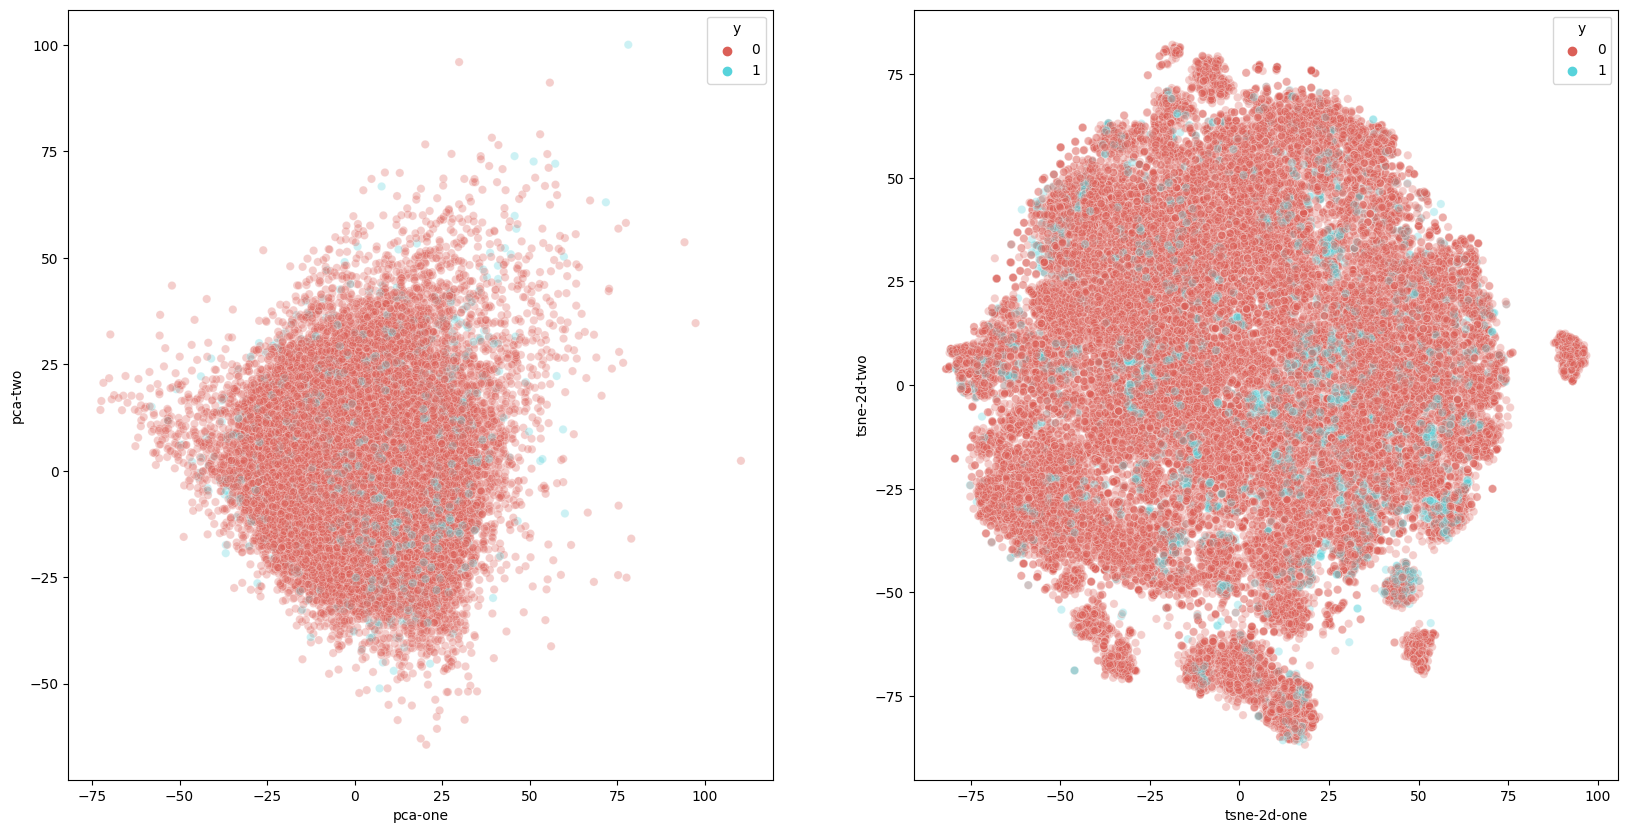

In [13]:
root='/home/neil/Lab_work/Jeong_Lab_Multi_Modal_MRI/magmsforEZprediction/'

# Load the data of all nodes of 68 patients
path = os.path.join(root,'NonEZvsEZ_whole_brain_patient_level')                
X_file = f"X_whole_brain.mat"
Y_file = f"Y_whole_brain.mat"    
X_mat_name = "X_whole_brain"
Y_mat_name = "Y_whole_brain"

raw_path_X = os.path.join(path,X_file)
raw_path_Y = os.path.join(path,Y_file)

"""Load the X Matrix from .mat files.""" 
X_mat_l = loadmat(raw_path_X)
X_combined_all_patients = X_mat_l[X_mat_name]

"""Load the Y Matrix from .mat files.""" 
Y_mat_l = loadmat(raw_path_Y)
Y_combined_all_patients = Y_mat_l[Y_mat_name]

# Perform z-score normalization across patients
X_combined_all_patients_norm = z_score_norm(X_combined_all_patients)  # type:ignore
print(f"X_all_patients max: {np.max(X_combined_all_patients_norm)}")
print(f"X_all_patients min: {np.min(X_combined_all_patients_norm)}")
Y_combined_all_patients = Y_combined_all_patients.reshape(Y_combined_all_patients.shape[1])

print('UnAugmented Y_all_patients shape %s' % Counter(Y_combined_all_patients)) 
# print(f"X shape: {X_combined_all_patients_norm.shape}") 
# print(f"Y shape: {Y_combined_all_patients.shape}")   

num_nodes=827
fold_no="1"
k_neighbors=6

# split the original data into training and validation (80%-20% split) 
X_train, Y_train, X_val, Y_val = orig_train_val_split(X_combined_all_patients_norm, Y_combined_all_patients, fold=fold_no, num_nodes=num_nodes) # type:ignore 

print(f"X-train shape: {X_train.shape}") 
print(f"Y-train shape: {Y_train.shape}")
print('UnAugmented Y_train shape %s' % Counter(Y_train)) 

print(f"X-val shape: {X_val.shape}") 
print(f"Y-val shape: {Y_val.shape}")
print('UnAugmented Y_val shape %s' % Counter(Y_val)) 

plot_tsne(X_train, Y_train)

Size of the dataframe: (11578, 1900)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11578 samples in 0.084s...
[t-SNE] Computed neighbors for 11578 samples in 3.314s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11578
[t-SNE] Computed conditional probabilities for sample 2000 / 11578
[t-SNE] Computed conditional probabilities for sample 3000 / 11578
[t-SNE] Computed conditional probabilities for sample 4000 / 11578
[t-SNE] Computed conditional probabilities for sample 5000 / 11578
[t-SNE] Computed conditional probabilities for sample 6000 / 11578
[t-SNE] Computed conditional probabilities for sample 7000 / 11578
[t-SNE] Computed conditional probabilities for sample 8000 / 11578
[t-SNE] Computed conditional probabilities for sample 9000 / 11578
[t-SNE] Computed conditional probabilities for sample 10000 / 11578
[t-SNE] Computed conditional probabilities for sample 11000 / 11578
[t-SNE] Computed conditional probabilities for sample 11578 / 11578
[t-SNE] Mean

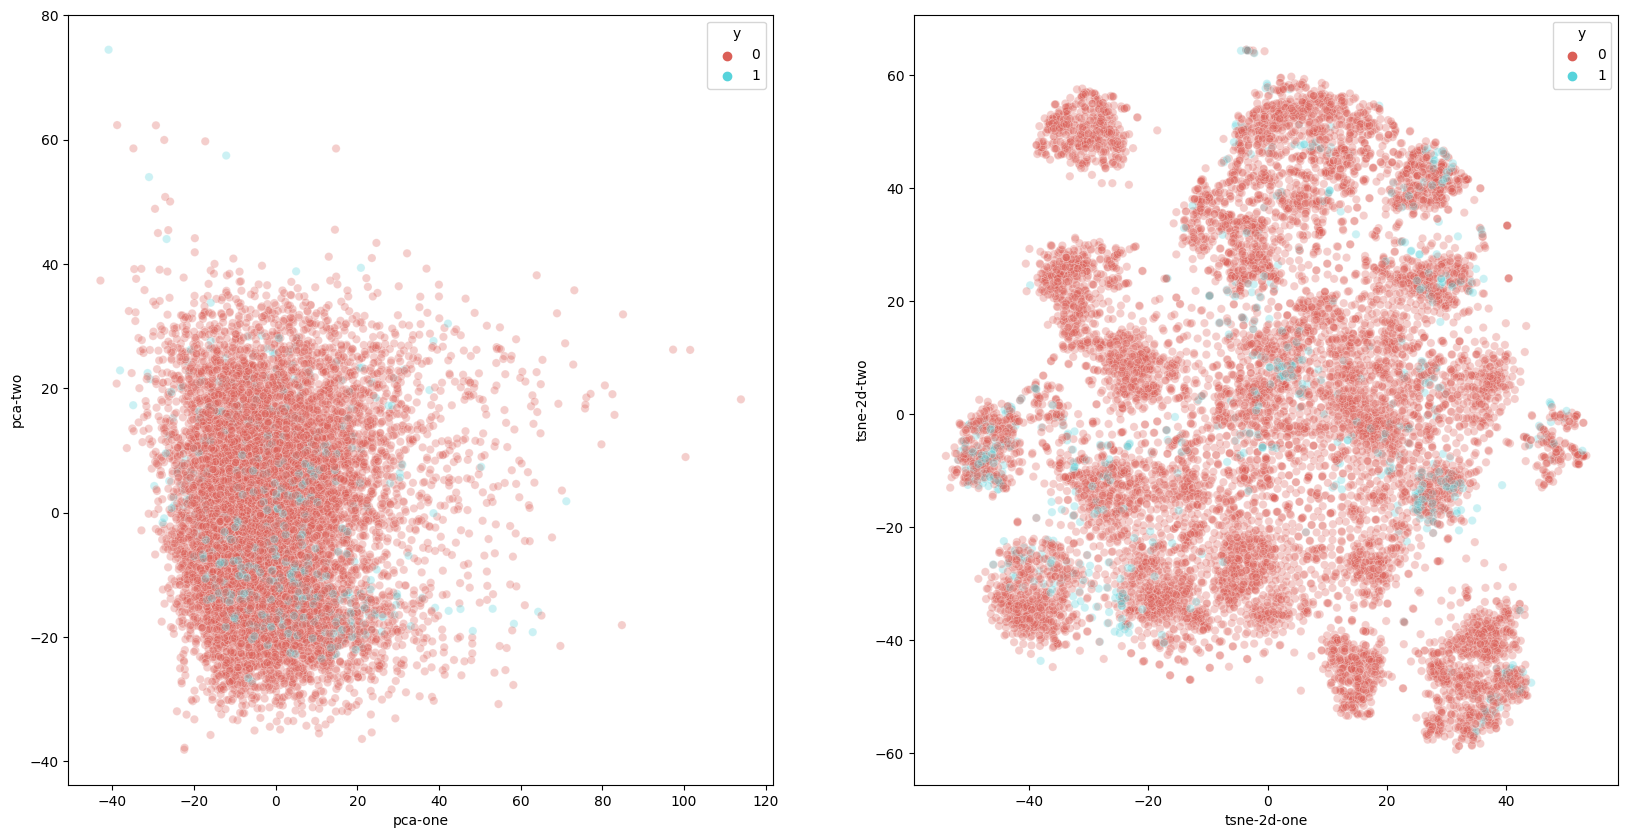

In [14]:
plot_tsne(X_val, Y_val)

In [17]:
num_nodes=827
fold_no="1"
k_neighbors=6

# augment data using SMOTE (balance dataset) for all 827 nodes of 68 patients
X_aug_all_patients, Y_aug_all_patients = augment_data(X_combined_all_patients_norm, Y_combined_all_patients, k_neighbors = k_neighbors, random_state=100) # type:ignore

print('Augmented Y_all_patients shape %s' % Counter(Y_aug_all_patients))

# split the data into training and validation (80%-20% split) 
X_train, Y_train, X_val, Y_val = aug_train_val_split(X_aug_all_patients, Y_aug_all_patients, fold=fold_no, num_nodes=num_nodes) # type:ignore 

Augmented Y_all_patients shape Counter({0: 51752, 1: 51752})


In [18]:
print(f"X-train shape: {X_train.shape}") 
print(f"Y-train shape: {Y_train.shape}")
print('Augmented Y_train shape %s' % Counter(Y_train)) 

print(f"X-val shape: {X_val.shape}") 
print(f"Y-val shape: {Y_val.shape}")
print('Augmented Y_val shape %s' % Counter(Y_val)) 


X-train shape: (81612, 1899)
Y-train shape: (81612,)
Augmented Y_train shape Counter({0: 40806, 1: 40806})
X-val shape: (21892, 1899)
Y-val shape: (21892,)
Augmented Y_val shape Counter({0: 10946, 1: 10946})


Size of the dataframe: (81612, 1900)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 81612 samples in 0.091s...
[t-SNE] Computed neighbors for 81612 samples in 149.501s...
[t-SNE] Computed conditional probabilities for sample 1000 / 81612
[t-SNE] Computed conditional probabilities for sample 2000 / 81612
[t-SNE] Computed conditional probabilities for sample 3000 / 81612
[t-SNE] Computed conditional probabilities for sample 4000 / 81612
[t-SNE] Computed conditional probabilities for sample 5000 / 81612
[t-SNE] Computed conditional probabilities for sample 6000 / 81612
[t-SNE] Computed conditional probabilities for sample 7000 / 81612
[t-SNE] Computed conditional probabilities for sample 8000 / 81612
[t-SNE] Computed conditional probabilities for sample 9000 / 81612
[t-SNE] Computed conditional probabilities for sample 10000 / 81612
[t-SNE] Computed conditional probabilities for sample 11000 / 81612
[t-SNE] Computed conditional probabilities for sample 12000 / 81612
[t-SNE] Co

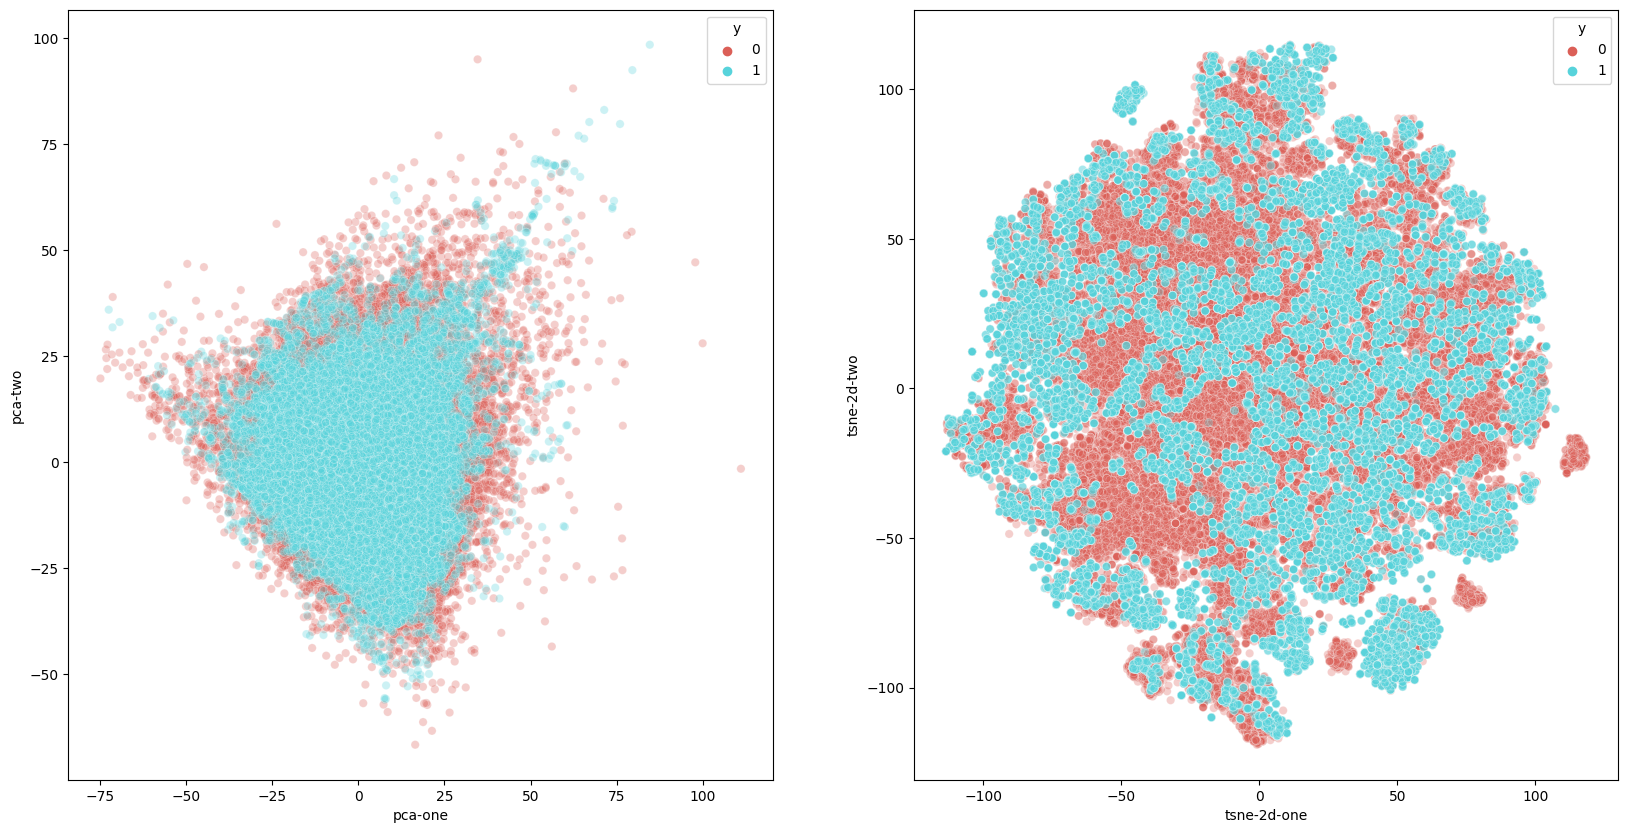

In [19]:
plot_tsne(X_train, Y_train)


Size of the dataframe: (21892, 1900)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 21892 samples in 0.026s...
[t-SNE] Computed neighbors for 21892 samples in 10.842s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21892
[t-SNE] Computed conditional probabilities for sample 2000 / 21892
[t-SNE] Computed conditional probabilities for sample 3000 / 21892
[t-SNE] Computed conditional probabilities for sample 4000 / 21892
[t-SNE] Computed conditional probabilities for sample 5000 / 21892
[t-SNE] Computed conditional probabilities for sample 6000 / 21892
[t-SNE] Computed conditional probabilities for sample 7000 / 21892
[t-SNE] Computed conditional probabilities for sample 8000 / 21892
[t-SNE] Computed conditional probabilities for sample 9000 / 21892
[t-SNE] Computed conditional probabilities for sample 10000 / 21892
[t-SNE] Computed conditional probabilities for sample 11000 / 21892
[t-SNE] Computed conditional probabilities for sample 12000 / 21892
[t-SNE] Com

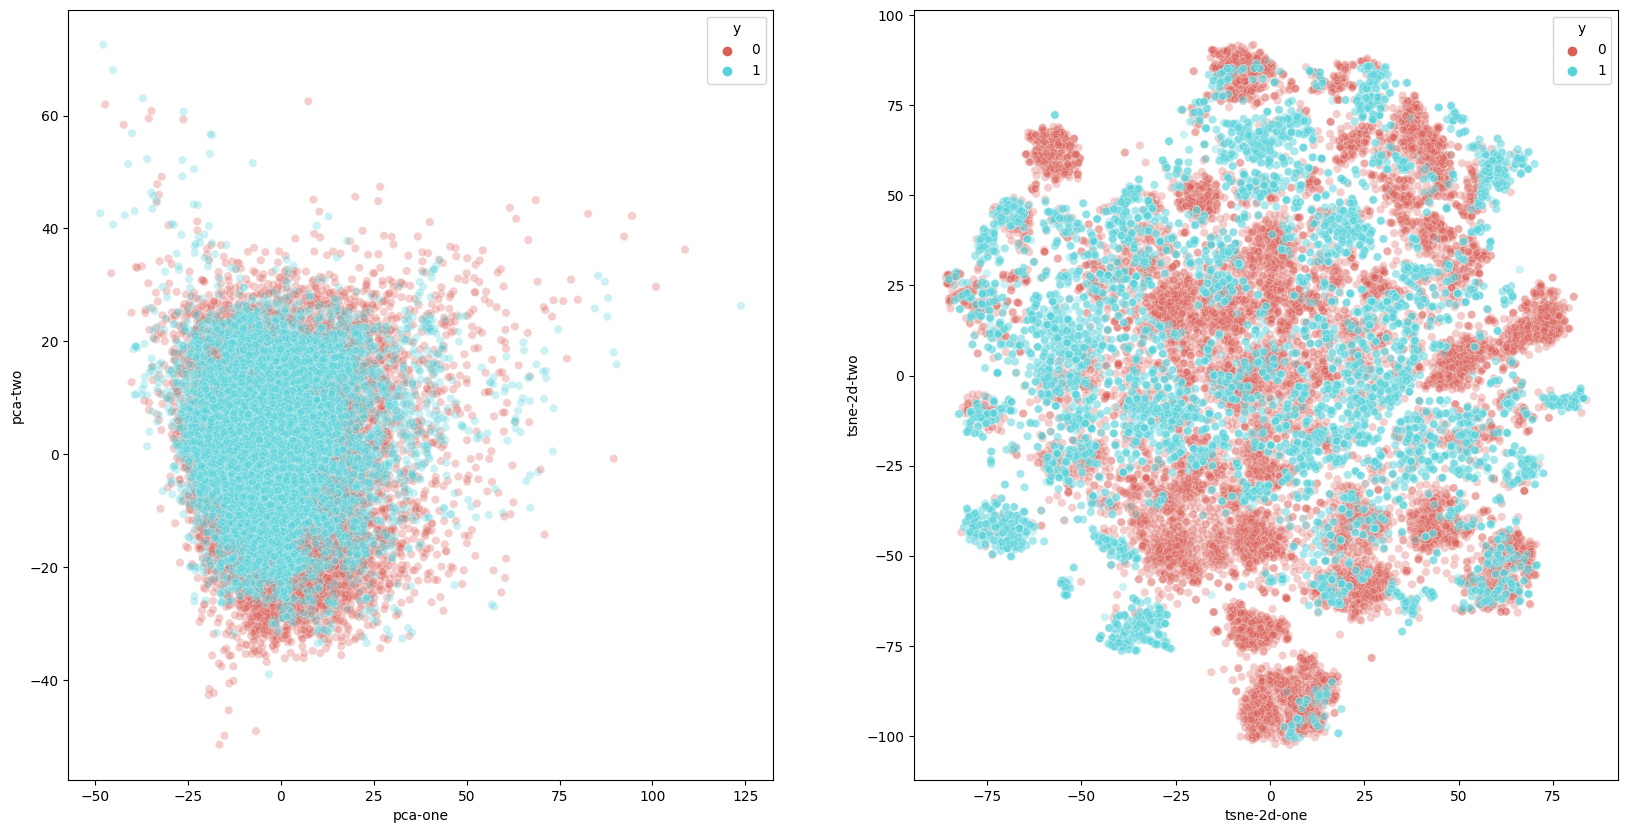

In [20]:
plot_tsne(X_val, Y_val)